In [57]:
import pandas as pd 
import numpy as np

excel_file = pd.ExcelFile("./data/factor_pricing_data.xlsx")

sheet_names = excel_file.sheet_names
sheet_names

['descriptions',
 'factors (excess returns)',
 'portfolios (excess returns)',
 'risk-free rate']

## Q2

In [58]:
df = pd.read_excel("./data/factor_pricing_data.xlsx", sheet_name="factors (excess returns)")
df = df.set_index("Date")
post_case = df.loc['2015':]


In [59]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

def portfolio_metrics_basic(returns: pd.DataFrame, annualization_factor: float) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df

In [60]:
portfolio_metrics_basic(df, 12)

,Annnualized Return,Annnualized Vol,Annnualized SR
MKT,0.086277,0.156904,0.549872
SMB,0.008319,0.101873,0.081665
HML,0.025809,0.109999,0.234629
RMW,0.047096,0.083213,0.565962
CMA,0.029537,0.073084,0.404148
UMD,0.062709,0.154564,0.405714


In [61]:
portfolio_metrics_basic(post_case, 12)

,Annnualized Return,Annnualized Vol,Annnualized SR
MKT,0.116586,0.160285,0.727369
SMB,-0.019500,0.104524,-0.186559
HML,-0.017855,0.132709,-0.134544
RMW,0.050886,0.073338,0.693862
CMA,-0.008410,0.083989,-0.100137
UMD,0.021083,0.140812,0.149723


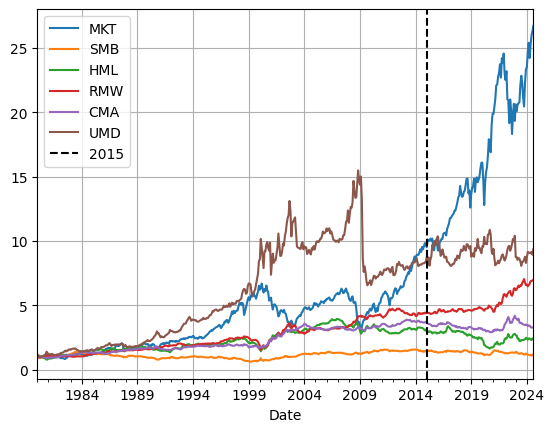

In [62]:
import matplotlib.pyplot as plt 
(df+1).cumprod().plot()
plt.axvline('2015', label = '2015', linestyle = '--', color = 'black')
plt.grid(True)
plt.legend()
plt.show()

#### (b) Interpretation 
- Based on the overall performance, the factors all have positive risk premium. However, since the time of hte case from 2015, we note that the factors - SMB, HML and CMA yielded a negative premium.
- The MKT portfolio showing a relatively strong outperformance. Since the start of the case (2015 - present), the factors have shown visible lacklustre performances with the exception of MKT that had a visible increase (alongside RMW). 

#### (c) Correlation Matrix

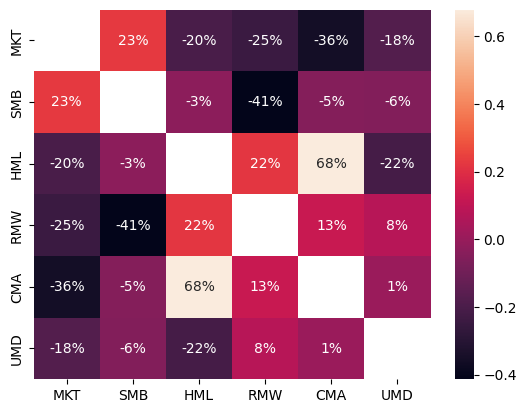

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_corr(data: pd.DataFrame):
    corr_mtx = data.corr() 
    corr_mtx[corr_mtx==1] = None
    sns.heatmap(corr_mtx,annot=True,fmt='.0%');

plot_corr(df)

HML shares a high positive correlation with CMA at 68% aand moderate correlation with RMW, then it is likely the factor is picking up on something similar to CMA. Therefore,it could be said to be the most redundant.

#### (d) Tangency Weights 

In [64]:
import numpy as np 

# returns is the main returns not annualized 
def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df

In [65]:
tangency_weights(df)

,Tangency Weights
MKT,0.209760
SMB,0.077337
HML,-0.042142
RMW,0.313263
CMA,0.338982
UMD,0.102798


In [66]:
portfolio_metrics_basic(df, 12)

,Annnualized Return,Annnualized Vol,Annnualized SR
MKT,0.086277,0.156904,0.549872
SMB,0.008319,0.101873,0.081665
HML,0.025809,0.109999,0.234629
RMW,0.047096,0.083213,0.565962
CMA,0.029537,0.073084,0.404148
UMD,0.062709,0.154564,0.405714


RMW, CMA and MKT seem to be the most important factors, with SMB and HML as one of the least important factors. 

Yes, they can still be useful especially with CMA and RMW though exhibiting a lower annualized return still having a 31.33% and 33.90% weight in the tangency portfolio. This is because we need to consider the risk adjusted returns as well and the covariances.

In [67]:
factors_sub = ['MKT', 'SMB', 'HML', 'UMD']
tangency_weights(df[factors_sub])

,Tangency Weights
MKT,0.365529
SMB,-0.032422
HML,0.356199
UMD,0.310694


High tangency weights: all except for SMB which is low. This shows that SMB is likely to not be important at all.

## Q3

In [68]:
data = pd.read_excel("./data/factor_pricing_data.xlsx", sheet_name="portfolios (excess returns)")
data.set_index('Date', inplace = True)
data.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726
1980-04-30,0.0449,0.0766,0.0232,0.0321,0.0830,-0.0529,0.0783,0.0153,0.0304,0.0115,...,0.0420,-0.0103,-0.0312,0.0353,0.0542,0.0728,0.0530,0.0977,0.0447,0.0769
1980-05-31,0.0632,0.0793,0.0457,0.0863,0.0815,0.0509,0.0324,0.0886,0.0560,0.0098,...,0.0564,0.1063,0.1142,0.0877,0.1134,0.0578,0.0557,0.0915,0.0844,0.0685


#### (a) AQR 4 Factor model 

In [69]:
aqr = df[['MKT', 'HML', 'RMW', 'UMD']]
aqr.head()

,MKT,HML,RMW,UMD
Date,,,,
1980-01-31,0.0551,0.0175,-0.0170,0.0755
1980-02-29,-0.0122,0.0061,0.0004,0.0788
1980-03-31,-0.1290,-0.0101,0.0146,-0.0955
1980-04-30,0.0397,0.0106,-0.0210,-0.0043
1980-05-31,0.0526,0.0038,0.0034,-0.0112


In [70]:
import statsmodels.api as sm 
results_df = pd.DataFrame(index = data.columns, columns = ['R square', 'Alpha'])
portfolios = list(data.columns) 
factors = aqr.copy()
for p in portfolios: 
    x = sm.add_constant(factors) 
    model = sm.OLS(data[p], x).fit() 
    r_squared = model.rsquared
    alpha = model.params['const'] 
    results_df.loc[p, 'R square'] = r_squared
    results_df.loc[p, 'Alpha'] = alpha
results_df   

,R square,Alpha
Agric,0.339175,0.000643
Food,0.464221,0.000579
Soda,0.308354,0.001436
Beer,0.420762,0.001422
Smoke,0.273489,0.002942
Toys,0.50834,-0.003111
Fun,0.616501,0.002542
Books,0.686774,-0.002452
Hshld,0.55841,-0.000674
Clths,0.618299,-0.001513


In [71]:
results_df['Alpha'].abs().mean() * 12

0.022992618979747928

The alpha estimates should be small since the pricing model should account for the excess returns of an asset. The MAE doesnt support the pricing model as well

#### (b) CAPM, FF3F, FF5F

In [72]:
ff_3_factors = ['MKT', 'SMB', 'HML']
ff_5_factors = ff_3_factors + ['RMW', 'CMA']
aqr = ['MKT', 'HML', 'RMW', 'UMD']
capm = ['MKT'] 

model_dict = {
    'ff3': ff_3_factors, 
    'ff5': ff_5_factors, 
    'aqr': aqr, 
    'capm': capm}



In [73]:
cols_of_interest = ['R square', 'Alpha']
models = ['aqr', 'capm', 'ff3', 'ff5']
combined_columns = [f"{model}_{col}" for col in cols_of_interest for model in models]

results_df = pd.DataFrame(index = data.columns, columns = combined_columns)
portfolios = list(data.columns) 
for p in portfolios: 
    for m in models: 
        cols = model_dict[m]
        x = sm.add_constant(df[cols]) 
        model = sm.OLS(data[p], x).fit() 
        r_squared = model.rsquared
        alpha = model.params['const'] 
        results_df.loc[p, f'{m}_R square'] = r_squared
        results_df.loc[p, f'{m}_Alpha'] = alpha
results_df   

,aqr_R square,capm_R square,ff3_R square,ff5_R square,aqr_Alpha,capm_Alpha,ff3_Alpha,ff5_Alpha
Agric,0.339175,0.330534,0.357393,0.363375,0.000643,0.001695,0.001344,0.000028
Food,0.464221,0.366464,0.416709,0.490799,0.000579,0.003818,0.00298,-0.00022
Soda,0.308354,0.25374,0.280459,0.313214,0.001436,0.003923,0.002899,-0.000153
Beer,0.420762,0.333662,0.36236,0.442389,0.001422,0.004953,0.004569,0.000846
Smoke,0.273489,0.189975,0.236211,0.305338,0.002942,0.00677,0.005512,0.000916
Toys,0.50834,0.495417,0.528722,0.549694,-0.003111,-0.00314,-0.003176,-0.0057
Fun,0.616501,0.599294,0.609808,0.613717,0.002542,0.000574,0.000528,0.001388
Books,0.686774,0.652329,0.688783,0.702782,-0.002452,-0.001206,-0.002111,-0.003698
Hshld,0.55841,0.493945,0.513703,0.589291,-0.000674,0.001765,0.001494,-0.001803
Clths,0.618299,0.558941,0.574434,0.628634,-0.001513,0.000044,-0.000513,-0.003385


#### (c) Interpretation

In [74]:
(results_df.loc[:, results_df.columns.str.contains('Alpha')].abs().mean()*12).to_frame('Annualized MAE')

,Annualized MAE
aqr_Alpha,0.022993
capm_Alpha,0.020402
ff3_Alpha,0.023984
ff5_Alpha,0.031367


It's hard to say. All of the models perform worse than the CAPM, so in some sense the only important factor is MKT. However, AQR performs second best, which further indicates that HML or CMA are redundant and should not be used. Yes, Fama and French should probably add the momentum factor to their model.

#### (d) Time Series Regressions

In [75]:
results_df.loc[:, results_df.columns.str.contains('R square')].mean().to_frame('R^2')

,R^2
aqr_R square,0.574935
capm_R square,0.526107
ff3_R square,0.571484
ff5_R square,0.595951


Not particularly. They only explain about 50-60% of the variation. This indicates moderately low explainability of excess returns by decomposition on different factor models. Thus the factors may not be considered good in a Linear Factor Decomposition of the assets.

#### (e) Cross Sectional Test

In [76]:
def calc_pricing_regression(rets, factors, intercept=True, adj=12):
    if intercept:
        factors = sm.add_constant(factors)
    summary = {f'{k} Beta': [] for k in factors.columns[1:]}
    summary['Alpha']  = []
    summary['R^2']    = []
    # for loops through the support portfolios
    for asset in rets.columns:
        model = sm.OLS(rets[asset], factors).fit()
        for k, _ in summary.items():
            try:
                summary[k].append(model.params[k[:-5]])
            except:
                pass
        summary['R^2'].append(model.rsquared)
        summary['Alpha'].append(model.params[0] * adj)
            
    return pd.DataFrame(summary, index=rets.columns)

def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params

ts_premia = data.mean() * 12

frames = [] 

for m in models:  
    cols = model_dict[m]
    pricing_regressions = calc_pricing_regression(data, df[cols])
    res = calc_cross_sectional_regression(ts_premia, pricing_regressions.iloc[:, :-2], intercept=False)
    res.columns = [f'{col}_{m}' for col in res.columns]
        
    frames.append(res)

# Concatenate after modifying column names
summary_cs = pd.concat(frames, axis=1).fillna('')
summary_cs_betas = summary_cs[summary_cs.index.str.contains('Beta')].copy()
summary_cs_betas.loc[:, 'Time Series'] = df.mean().values * 12
summary_cs_betas

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_976/768902637.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary['Alpha'].append(model.params[0] * adj)
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_976/768902637.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary['Alpha'].append(model.params[0] * adj)
/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_976/768902637.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

,Cross Sectional Regression_aqr,Cross Sectional Regression_capm,Cross Sectional Regression_ff3,Cross Sectional Regression_ff5,Time Series
MKT Beta,0.089125,0.086096,0.102214,0.096486,0.086277
HML Beta,-0.038711,,-0.015204,-0.030994,0.008319
RMW Beta,0.043748,,,0.033605,0.025809
UMD Beta,0.060747,,,,0.047096
SMB Beta,,,-0.064485,-0.056991,0.029537
CMA Beta,,,,-0.011559,0.062709


In [77]:
summary_cs_betas

,Cross Sectional Regression_aqr,Cross Sectional Regression_capm,Cross Sectional Regression_ff3,Cross Sectional Regression_ff5,Time Series
MKT Beta,0.089125,0.086096,0.102214,0.096486,0.086277
HML Beta,-0.038711,,-0.015204,-0.030994,0.008319
RMW Beta,0.043748,,,0.033605,0.025809
UMD Beta,0.060747,,,,0.047096
SMB Beta,,,-0.064485,-0.056991,0.029537
CMA Beta,,,,-0.011559,0.062709


- For MKT, not much difference. likewise for UMD and RMW. However, there is a big difference for the others where alot of the estimated premia are negative. 

In [78]:
summary_cs.loc['MAE', :]


Cross Sectional Regression_aqr     0.016456
Cross Sectional Regression_capm    0.020384
Cross Sectional Regression_ff3     0.015113
Cross Sectional Regression_ff5     0.013021
Name: MAE, dtype: object

In [79]:
(results_df.loc[:, results_df.columns.str.contains('Alpha')].abs().mean()*12).to_frame('Time Series MAE')

,Time Series MAE
aqr_Alpha,0.022993
capm_Alpha,0.020402
ff3_Alpha,0.023984
ff5_Alpha,0.031367


They are mostly smaller than the time series MAE except for CAPM which is slightly higher.